In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: load the validated datasets
print("Loading the validated datasets...")
train_final = pd.read_csv('engineered_data/fraudTrain_engineered.csv')
test_final = pd.read_csv('engineered_data/fraudTest_engineered.csv')

Loading the validated datasets...


In [3]:
# Step 2: prepare features and target
# encode gender using one-hot encoding
train_final = pd.get_dummies(train_final, columns=['gender'], drop_first=True)
test_final = pd.get_dummies(test_final, columns=['gender'], drop_first=True)

In [4]:
# define features 
features = [col for col in train_final.columns if col != 'is_fraud']
X_train = train_final[features]
y_train = train_final['is_fraud']
X_test = test_final[features]
y_test = test_final['is_fraud']

In [5]:
# Step 3: define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

In [6]:
# Step 4: set up GridSearchCV
print("Setting up GridSearchCV for hyperparameter tuning...")
xgb_model = XGBClassifier(random_state=42, enable_categorical=True)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)

Setting up GridSearchCV for hyperparameter tuning...


In [7]:
# Step 5: fit the model with hyperparameter tuning
print("Fitting the model with hyperparameter tuning...")
grid_search.fit(X_train, y_train)

Fitting the model with hyperparameter tuning...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'scale_pos_weight': [171.75179856115108]},
             scoring='f1', verbose=2)

In [8]:
# Step 6: get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 171.75179856115108}


In [9]:
# Step 7: get predicted probabilities using the best model
print("Generating predicted probabilities with the best model...")
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  

Generating predicted probabilities with the best model...


In [10]:
# Step 8: test different thresholds
thresholds = [0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]
for thresh in thresholds:
    y_pred = (y_pred_prob > thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_pred))


Threshold: 0.8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.51      0.90      0.65      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.95      0.82    555719
weighted avg       1.00      1.00      1.00    555719


Threshold: 0.9
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.63      0.87      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.81      0.93      0.86    555719
weighted avg       1.00      1.00      1.00    555719


Threshold: 0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.76      0.83      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.92      0.90    555719
weighted avg       1.00  

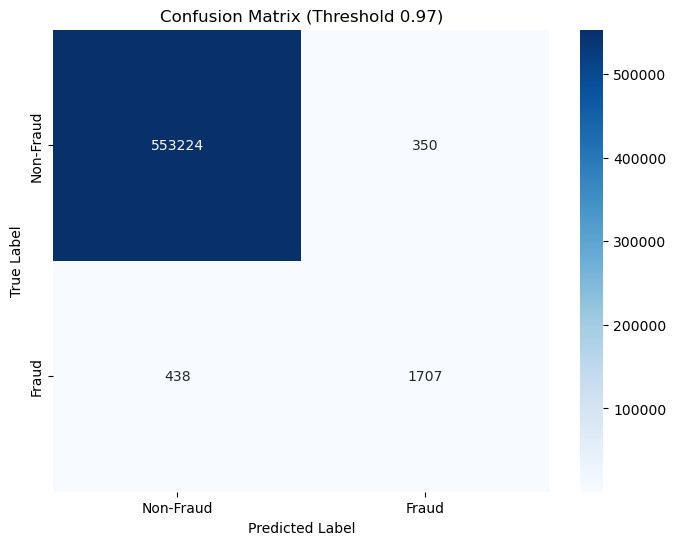

In [ ]:
# Step 9: visualize results
# visualize confusion matrix for the best threshold 
cm = confusion_matrix(y_test, (y_pred_prob > 0.97).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix (Threshold 0.97)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

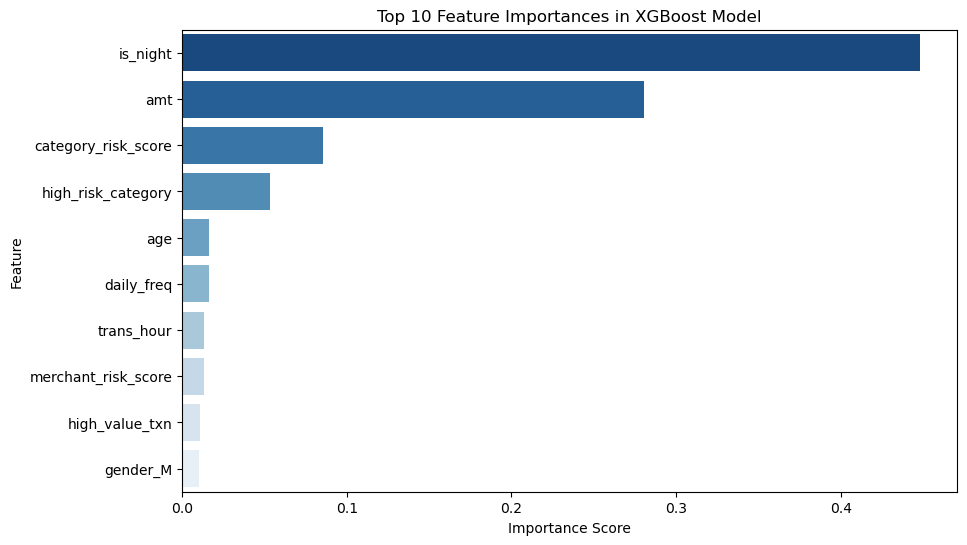

In [15]:
# 9.2: feature importance for top 10 features
feature_importance = best_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importance_df, palette='Blues_r', legend=False)
plt.title('Top 10 Feature Importances in XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

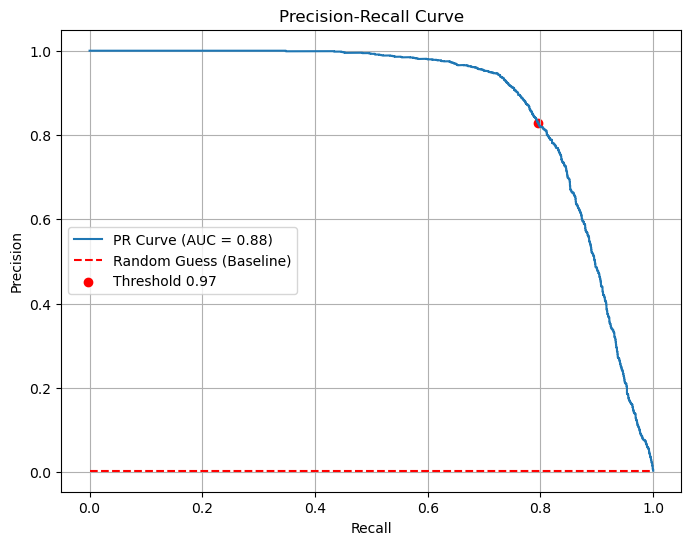

In [ ]:
# 9.3: precision-recall curve
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.plot([0, 1], [0.004, 0.004], 'r--', label='Random Guess (Baseline)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# mark the chosen threshold (0.97) on the curve
chosen_recall_idx = (np.abs(thresholds - 0.97)).argmin()
plt.scatter(recall[chosen_recall_idx], precision[chosen_recall_idx], c='red', label=f'Threshold 0.97')
plt.legend()
plt.show()

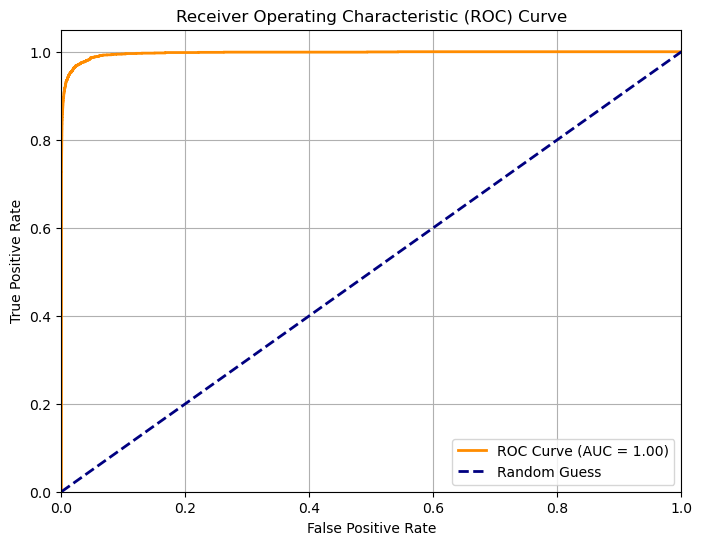

ROC-AUC Score: 0.9967


In [ ]:
# Step 10: calculate and plot ROC-AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

Average Fraud Loss (FN Cost): $530.66
Estimated Investigation Cost (FP Cost): $75.00
Threshold: 0.8, Total Cost: $258,823.82
Threshold: 0.9, Total Cost: $234,049.83
Threshold: 0.95, Total Cost: $231,734.80
Threshold: 0.96, Total Cost: $241,146.63
Threshold: 0.97, Total Cost: $258,679.70
Threshold: 0.98, Total Cost: $275,837.77
Threshold: 0.99, Total Cost: $306,320.39


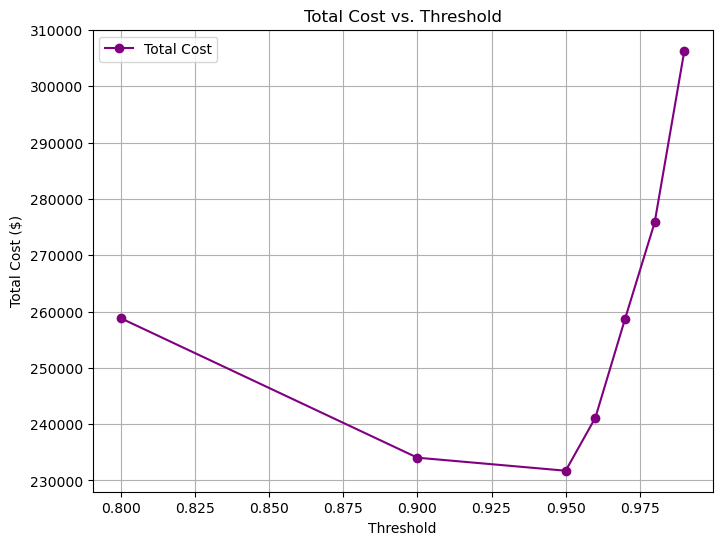

Threshold with minimum cost: 0.95, Cost: $231,734.80


In [23]:
# Step 11: Cost Analysis
import numpy as np
from sklearn.metrics import confusion_matrix

# calculate average fraud loss (FN cost) from transaction amounts
full_data = pd.concat([train_final, test_final])
fraud_data = full_data[full_data['is_fraud'] == 1]
average_fraud_loss = fraud_data['amt'].mean()
print(f"Average Fraud Loss (FN Cost): ${average_fraud_loss:.2f}")

# estimate investigation cost (FP cost) 
investigation_cost = 75  
print(f"Estimated Investigation Cost (FP Cost): ${investigation_cost:.2f}")

# define costs 
cost_fp = investigation_cost   # cost of investigating a false positive 
cost_fn = average_fraud_loss  # cost of missing a fraudulent transaction 

# use the same thresholds 
thresholds = [0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]
costs = []

# calculate costs for each threshold
for thresh in thresholds:
    y_pred = (y_pred_prob > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    costs.append(total_cost)
    print(f"Threshold: {thresh}, Total Cost: ${total_cost:,.2f}")

# plot total cost vs. threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, costs, marker='o', color='purple', label='Total Cost')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Total Cost vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

# find the threshold with the minimum cost
min_cost_idx = np.argmin(costs)
min_cost_threshold = thresholds[min_cost_idx]
print(f"Threshold with minimum cost: {min_cost_threshold}, Cost: ${costs[min_cost_idx]:,.2f}")